In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#!pip install segmentation-models

In [3]:
# Import related dependencies
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import json
from matplotlib.colors import to_rgb

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm
import random

2022-11-09 21:16:22.870933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


In [4]:
# Define categories and colors
dict = {'classes' : ['Building','Land (unpaved area)','Road','Vegetation', 'Water','Unlabeled'],
        'colors' : ['#3C1098', '#8429F6', '#6EC1E4', '#FEDD3A', '#E2A929', '#9B9B9B']}

patch_size = 256

In [5]:
# Returns the size of labelize
def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for i,col in enumerate(dict['colors']):
        color = np.array([255 * x for x in to_rgb(col)]).astype('uint8')
        ref[np.all(label == color,axis=-1)] = i
    return ref
# Image scaling according to patch_size
def patchify(img):
    m,n,b = img.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(img[i:i+patch_size,j:j+patch_size,:])
    return crops
# Modify the label corresponding to patchify
def patchify_lab(label):
    m,n = label.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(label[i:i+patch_size,j:j+patch_size])
    return crops

# Calculate jaccard similarity coefficient a∩b/(a∪b)
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [6]:
# Define the dataset path
folder = r"../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
tiles = os.listdir(folder)
train_set = []
train_lab = []
test_set = []
test_lab = []
# traverse data
for tile in tiles:
    if os.path.isdir(os.path.join(folder,tile)):
        files = os.listdir(os.path.join(folder,tile,'images'))
        for file in files:
            # Read uav image
            img = imageio.imread(os.path.join(folder,tile,'images',file))/255
            img = patchify(img)
            label = imageio.imread(os.path.join(folder,tile,'masks',file[:-3] + 'png'))
            label = labelize(label)
            label = patchify_lab(label)

            if file == 'image_part_009.jpg':
                test_set = test_set + img
                test_lab = test_lab + label
            else:
                train_set = train_set + img
                train_lab = train_lab + label
# Load the training and testing datasets                
train_set = np.array(train_set)  
test_set = np.array(test_set)  
train_lab = np.array(train_lab) 
n_classes = len(np.unique(train_lab)) 
# One-hot encoding of training data labels
train_lab = to_categorical(train_lab, num_classes=n_classes)
test_lab = np.array(test_lab)  
# One-hot encoding of test data labels
test_lab = to_categorical(test_lab, num_classes=n_classes)
print(train_set.shape)
print(test_set.shape)
print(train_lab.shape)
print(test_lab.shape)
       

/var/folders/17/yhlj1g9j1xx1bvm73c4rksc80000gn/T/ipykernel_29289/4284393691.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder,tile,'images',file))/255
/var/folders/17/yhlj1g9j1xx1bvm73c4rksc80000gn/T/ipykernel_29289/4284393691.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(os.path.join(folder,tile,'masks',file[:-3] + 'png'))
/var/folders/17/yhlj1g9j1xx1bvm73c4rksc80000gn/T/ipykernel_29289/3508916184.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ref[np.all(labe

(1160, 256, 256, 3)
(145, 256, 256, 3)
(1160, 256, 256, 6)
(145, 256, 256, 6)


![在这里插入图片描述](https://img-blog.csdnimg.cn/img_convert/cb72528b58601712e0d3a94fdeb4b751.png#pic_center)

In [7]:
# Build the unet network according to the above figure
def unet_model(n_classes=n_classes, IMG_HEIGHT=patch_size, IMG_WIDTH=patch_size, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
# Defining accuracy as a metric for training a model
metrics=['accuracy', jaccard_coef]
# Define loss
loss = sm.losses.DiceLoss() 
# call model
model= unet_model()
# View model information
model.summary()
# Define the optimizer and perform training precompilation
model.compile(optimizer='adam', loss=loss, metrics=metrics)


2022-11-09 21:17:01.698013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 6)  102         ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,941,190
Trainable params: 1,941,190
Non-trainable params: 0
__________________________________________________________________________________________________


In [9]:
# load model callback function
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
# resume training
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [10]:
# split data
X_train, X_val, y_train, y_val = train_test_split(train_set, train_lab, test_size = 0.20, random_state = 42)

In [11]:
# model training
history = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=30, 
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/30
116/116 [==============================] - 277s 2s/step - loss: 0.6960 - accuracy: 0.5946 - jaccard_coef: 0.4017 - val_loss: 0.5924 - val_accuracy: 0.6846 - val_jaccard_coef: 0.5198
Epoch 2/30
116/116 [==============================] - 253s 2s/step - loss: 0.6168 - accuracy: 0.6522 - jaccard_coef: 0.4865 - val_loss: 0.5567 - val_accuracy: 0.6998 - val_jaccard_coef: 0.5382
Epoch 3/30
116/116 [==============================] - 233s 2s/step - loss: 0.5123 - accuracy: 0.7285 - jaccard_coef: 0.5744 - val_loss: 0.4829 - val_accuracy: 0.7378 - val_jaccard_coef: 0.5884
Epoch 4/30
116/116 [==============================] - 241s 2s/step - loss: 0.4878 - accuracy: 0.7380 - jaccard_coef: 0.5912 - val_loss: 0.4678 - val_accuracy: 0.7508 - val_jaccard_coef: 0.6056
Epoch 5/30
116/116 [==============================] - 216s 2s/step - loss: 0.4629 - accuracy: 0.7613 - jaccard_coef: 0.6186 - val_loss: 0.4545 - val_accuracy: 0.7503 - val_jaccard_coef: 0.6046
Epoch 6/30
116/116 [===============

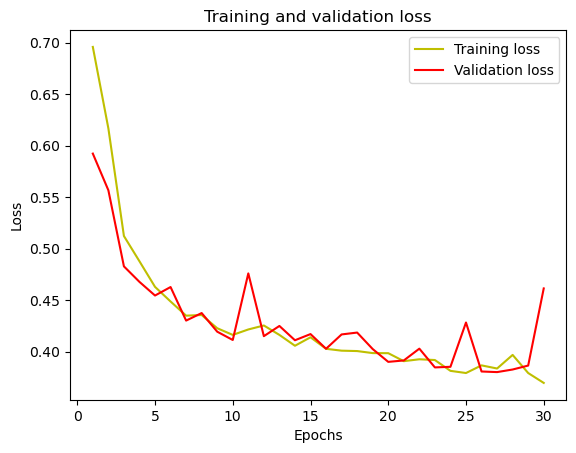

In [12]:
# draw the model loss curve
# Get all loss sets
loss = history.history['loss']
# Take out all validation set loss sets
val_loss = history.history['val_loss']
# Calculate training times
epochs = range(1, len(loss) + 1)
# plot the training set loss
plt.plot(epochs, loss, 'y', label='Training loss')
# plot the test set loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')
# Define drawing image parameters
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Conclusion The training set and verification set are decreasing with the increase of epoch, and finally stabilized at around 0.4

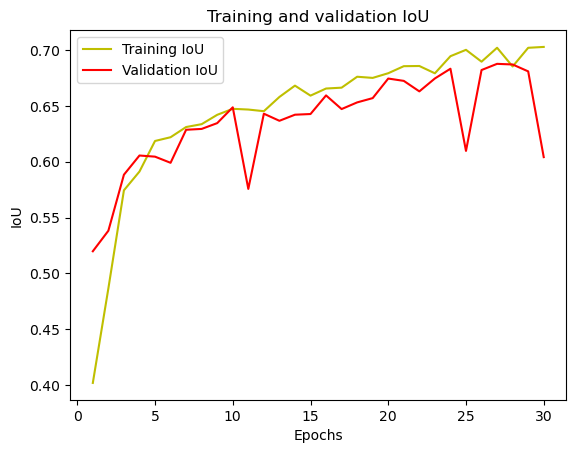

In [13]:
# Take out all training set jaccard coefficient sets
acc = history.history['jaccard_coef']
# Take out all test set jaccard coefficient sets
val_acc = history.history['val_jaccard_coef']
# Draw the IOU value of the training set. The IOU can reflect the quality of the unet model. The larger the value, the better the semantic segmentation effect
plt.plot(epochs, acc, 'y', label='Training IoU')
# Draw the IOU value of the verification set. The IOU can reflect the quality of the unet model. The larger the value, the better the semantic segmentation effect
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
# Define drawing image parameters
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()
# Conclusion: As the number of training increases: the larger the value of iou, the better the model fitting effect

In [14]:
# Make model predictions
y_pred=model.predict(test_set)
# Calculate the value of the test set iou
Jacc = jaccard_coef(test_lab,y_pred)
print('IoU = {}'.format(Jacc))
# Calculate the maximum position of the y prediction and the maximum position of the test set label
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_lab, axis=3)
# Conclusion, the iou value of the unet model defined by the first layer of fitting is 0.709

5/5 [==============================] - 13s 2s/step
IoU = 0.7094420790672302


1/1 [==============================] - 0s 176ms/step


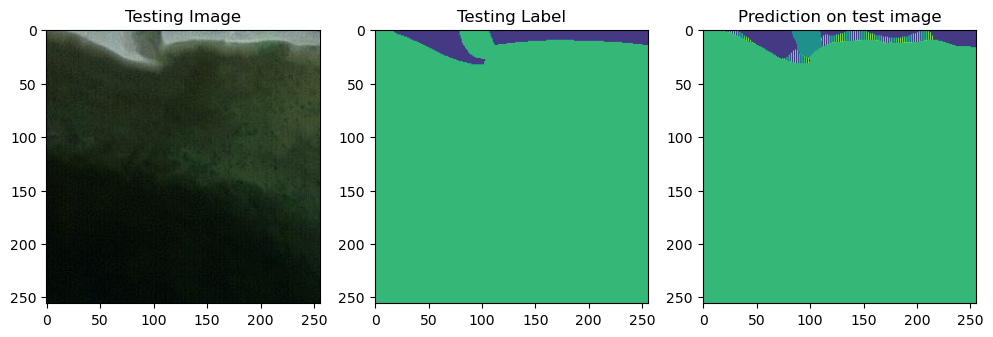

1/1 [==============================] - 0s 137ms/step


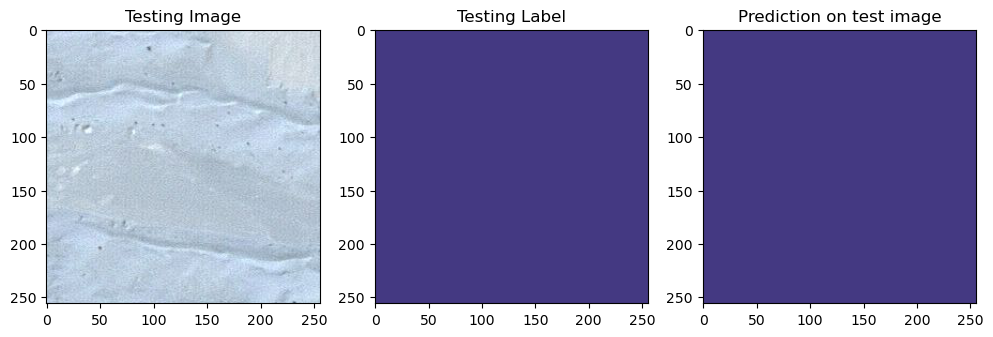

1/1 [==============================] - 0s 132ms/step


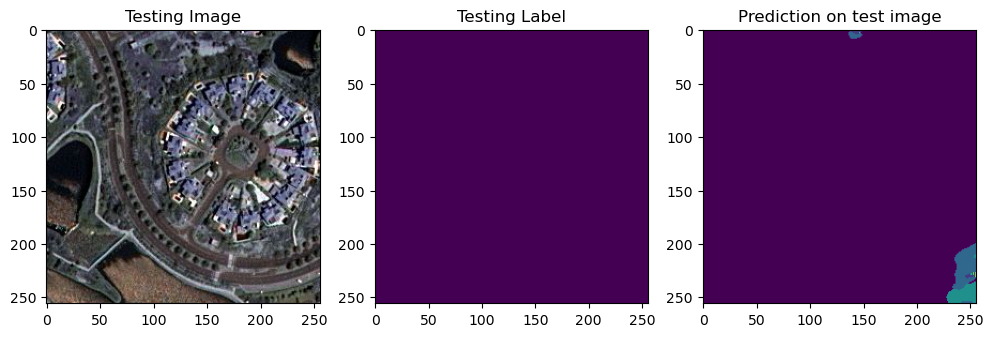

1/1 [==============================] - 0s 136ms/step


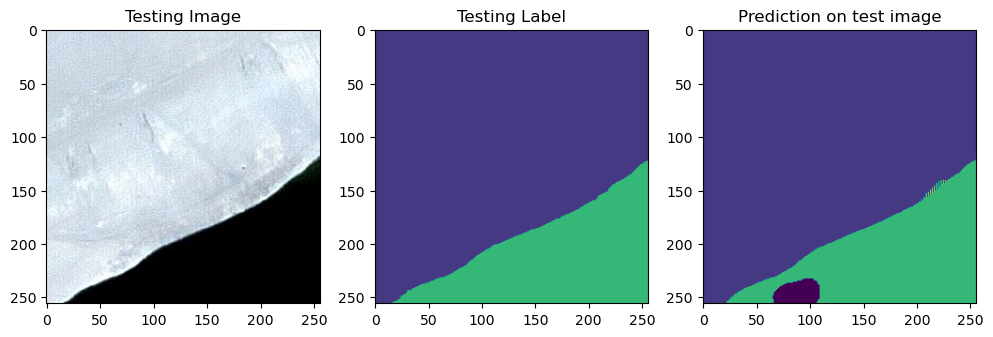

1/1 [==============================] - 0s 127ms/step


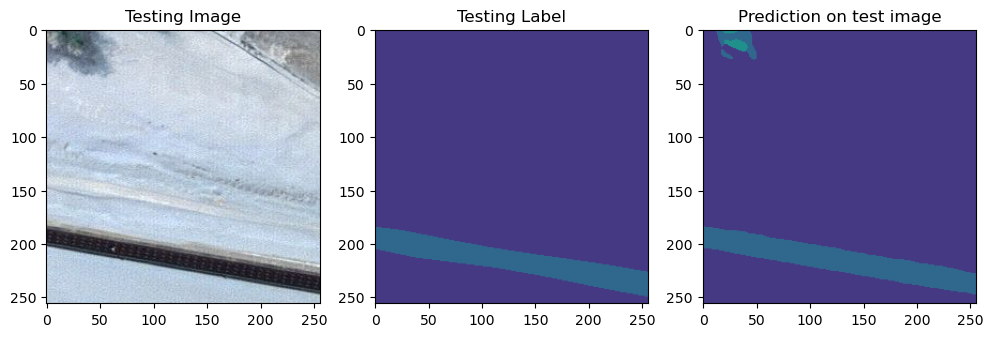

1/1 [==============================] - 0s 143ms/step


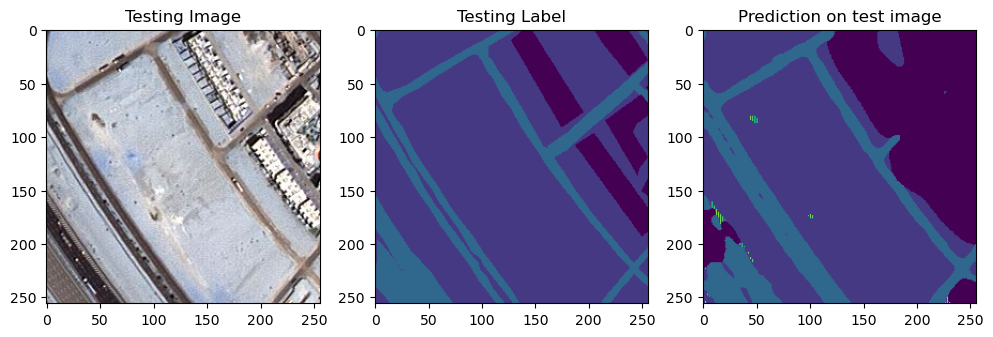

1/1 [==============================] - 0s 125ms/step


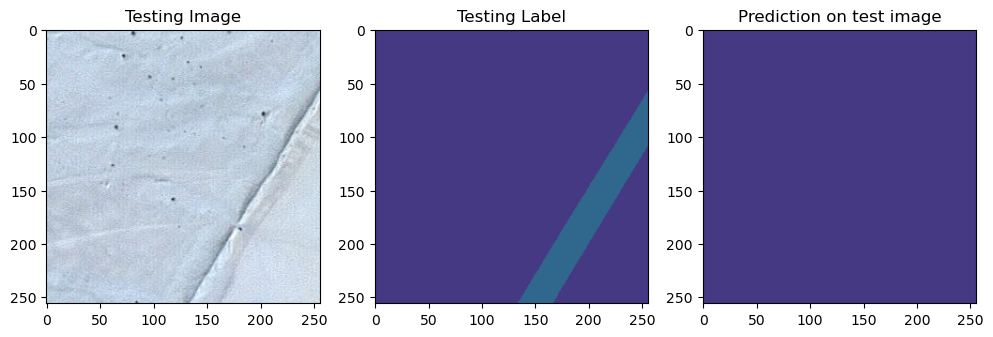

1/1 [==============================] - 0s 126ms/step


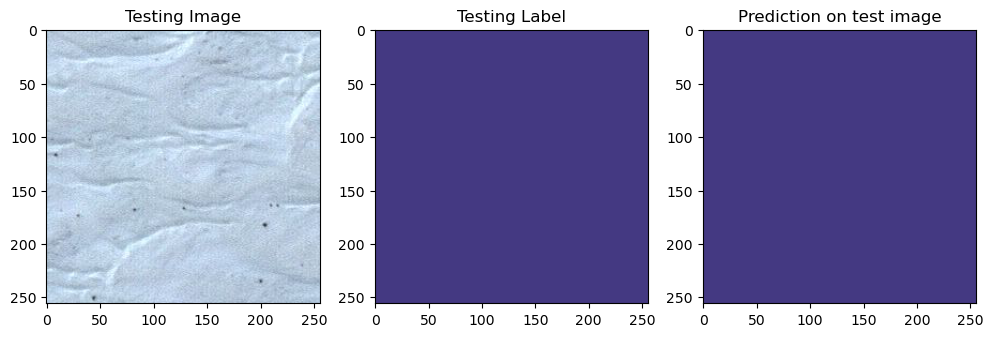

1/1 [==============================] - 0s 124ms/step


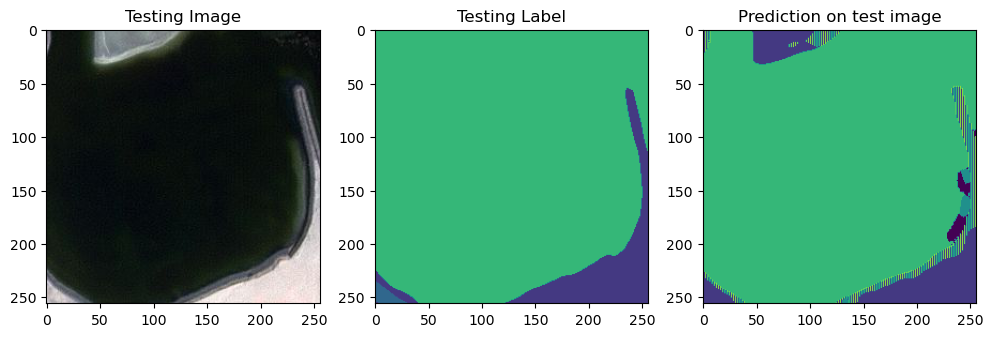

1/1 [==============================] - 0s 127ms/step


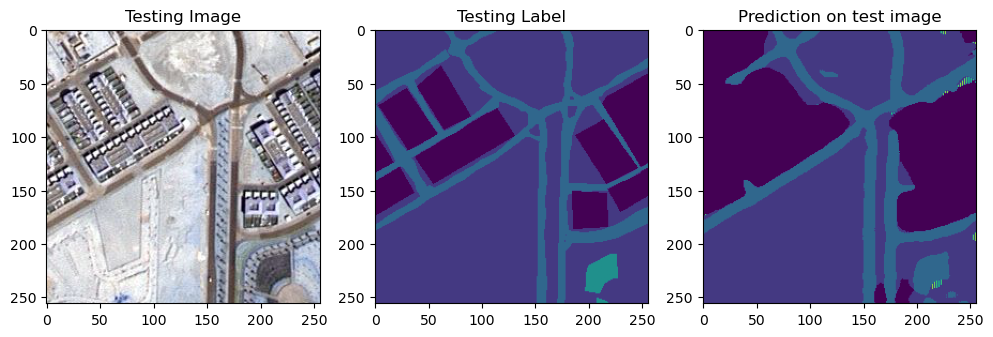

In [15]:
# Display some sample data
# Define the number of samples
num_samples = 10
# Randomly load data
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
# loop loading
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    # Add a dimension
    test_img_input=np.expand_dims(test_img, 0)
    # Use the trained model to make predictions
    prediction = (model.predict(test_img_input))
    # Calculate the label corresponding to the predicted value
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    # Define drawing image parameters
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()

In [16]:
# Perform model optimization
# On the basis of the original unet model, perform a Dropout after each convolutional layer is calculated to optimize the unet network model
from tensorflow.keras.layers import Dropout
def unet_model2(n_classes=n_classes, IMG_HEIGHT=patch_size, IMG_WIDTH=patch_size, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    # Dropout
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [17]:
# define accuracy as the measure for training the model
metrics=['accuracy', jaccard_coef]
loss = sm.losses.DiceLoss() 
# Load the optimized unst model
model2= unet_model2()
model2.summary()
model2.compile(optimizer='adam', loss=loss, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_8[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [18]:
# define the callback function
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [19]:
# Train optimized unet
history2 = model2.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=30, 
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/30
116/116 [==============================] - 421s 4s/step - loss: 0.7280 - accuracy: 0.5665 - jaccard_coef: 0.3521 - val_loss: 0.6088 - val_accuracy: 0.6883 - val_jaccard_coef: 0.4773
Epoch 2/30
116/116 [==============================] - 422s 4s/step - loss: 0.5387 - accuracy: 0.7159 - jaccard_coef: 0.5571 - val_loss: 0.5026 - val_accuracy: 0.7338 - val_jaccard_coef: 0.5834
Epoch 3/30
116/116 [==============================] - 409s 4s/step - loss: 0.4811 - accuracy: 0.7485 - jaccard_coef: 0.6044 - val_loss: 0.4740 - val_accuracy: 0.7411 - val_jaccard_coef: 0.5946
Epoch 4/30
116/116 [==============================] - 422s 4s/step - loss: 0.4551 - accuracy: 0.7702 - jaccard_coef: 0.6312 - val_loss: 0.4390 - val_accuracy: 0.7731 - val_jaccard_coef: 0.6348
Epoch 5/30
116/116 [==============================] - 404s 3s/step - loss: 0.4379 - accuracy: 0.7793 - jaccard_coef: 0.6434 - val_loss: 0.4415 - val_accuracy: 0.7659 - val_jaccard_coef: 0.6250
Epoch 6/30
116/116 [===============

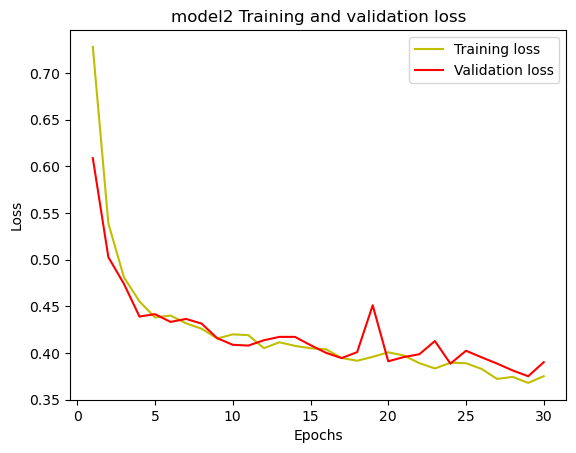

In [20]:
# Show the training set and test set loss changes of the optimized unet model as above
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('model2 Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# With the increase of epoch, the loss of training set and test set is decreasing, and it is more stable than before

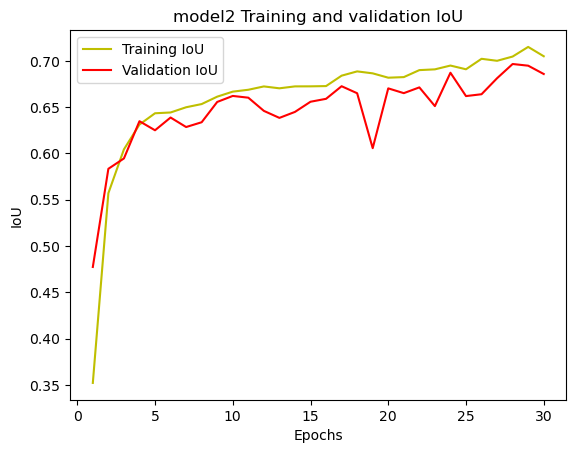

In [21]:
# Show the changes in the training set and test set IOU of the optimized unet model as above
acc = history2.history['jaccard_coef']
val_acc = history2.history['val_jaccard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('model2 Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()
# Conclusion With the increase of epoch, the loss of training set and test set is increasing

In [22]:
# Calculate the optimized iou
y_pred=model2.predict(test_set)
Jacc = jaccard_coef(test_lab,y_pred)
print('IoU = {}'.format(Jacc))
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_lab, axis=3)
# Conclusion, the optimized iou value of 0.774 is much more accurate than the previous value of 0.70, which proves that the optimization effect is obvious

5/5 [==============================] - 13s 2s/step
IoU = 0.7745313048362732


1/1 [==============================] - 0s 170ms/step


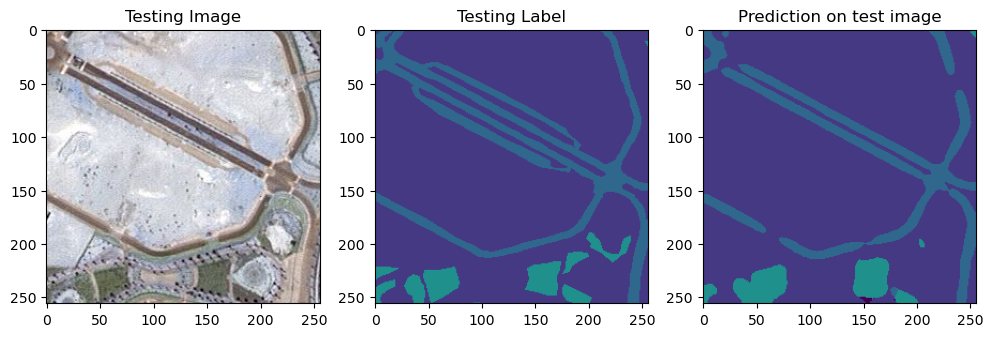

1/1 [==============================] - 0s 143ms/step


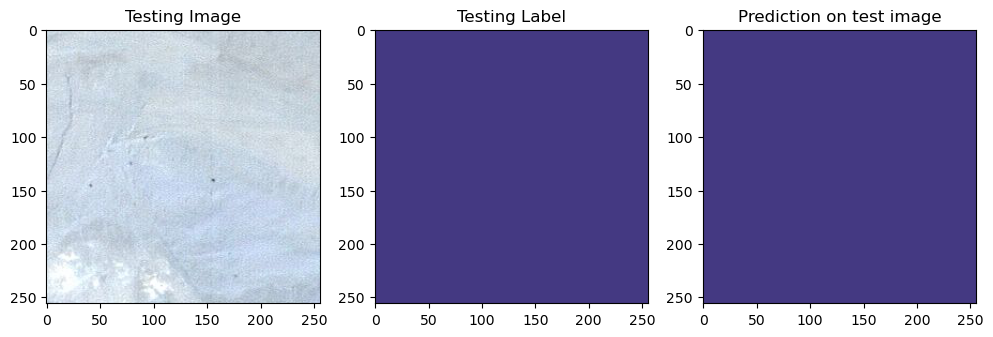

1/1 [==============================] - 0s 127ms/step


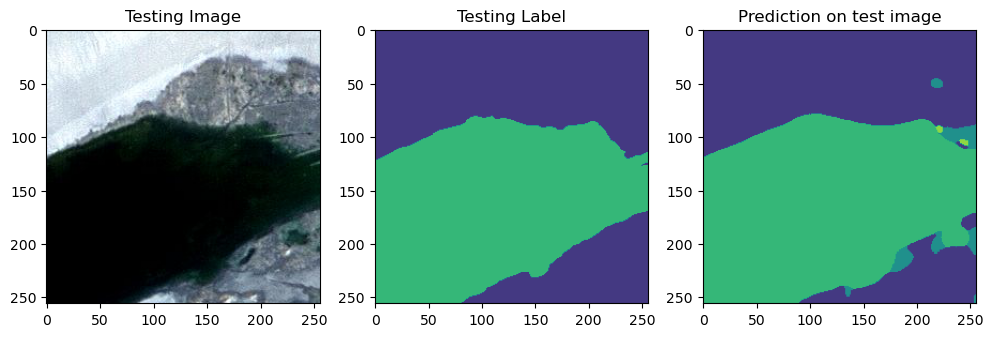

1/1 [==============================] - 0s 128ms/step


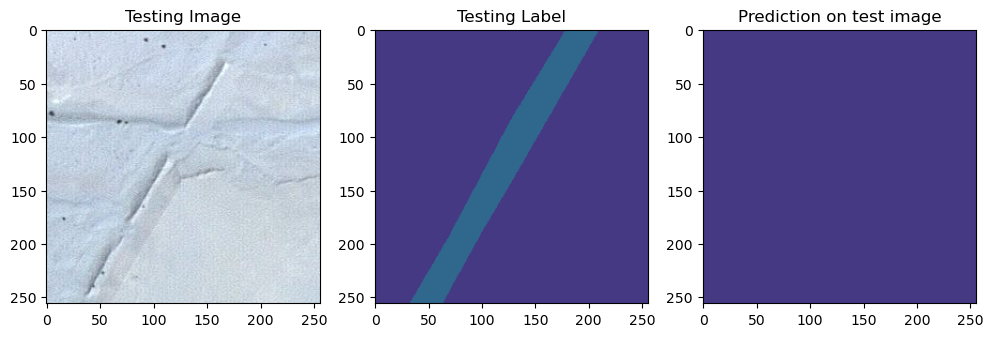

1/1 [==============================] - 0s 129ms/step


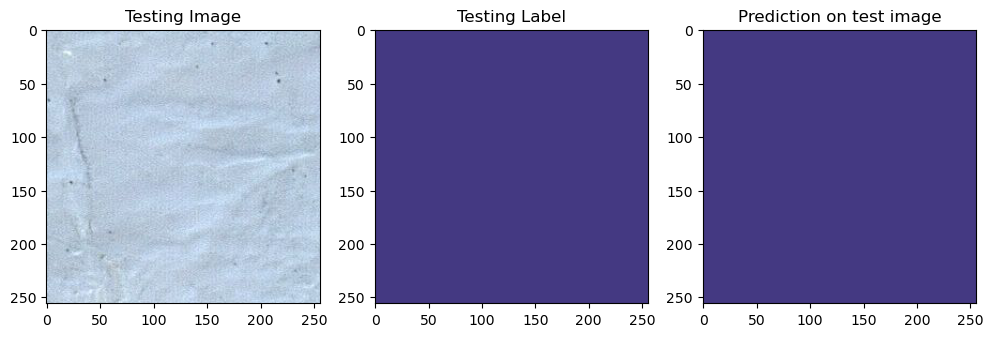

1/1 [==============================] - 0s 127ms/step


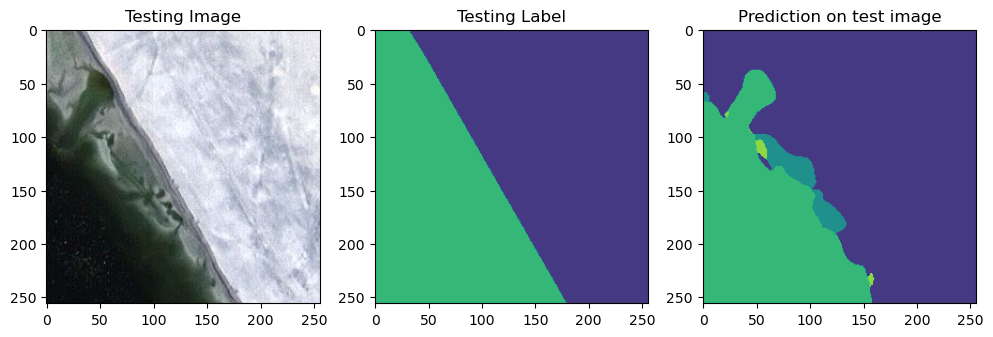

1/1 [==============================] - 0s 129ms/step


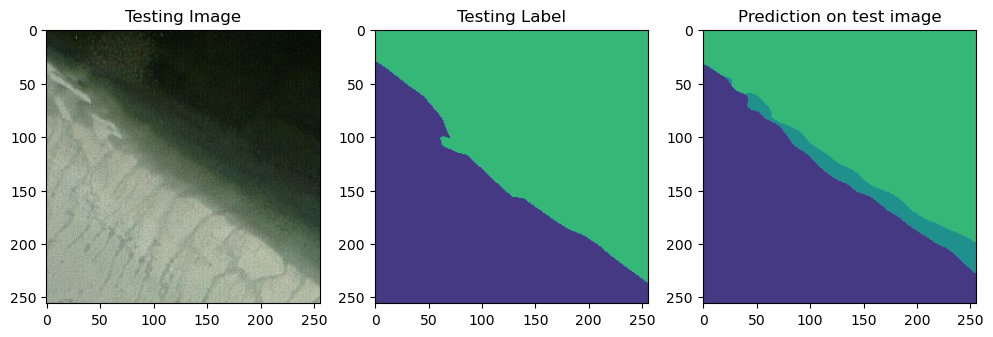

1/1 [==============================] - 0s 129ms/step


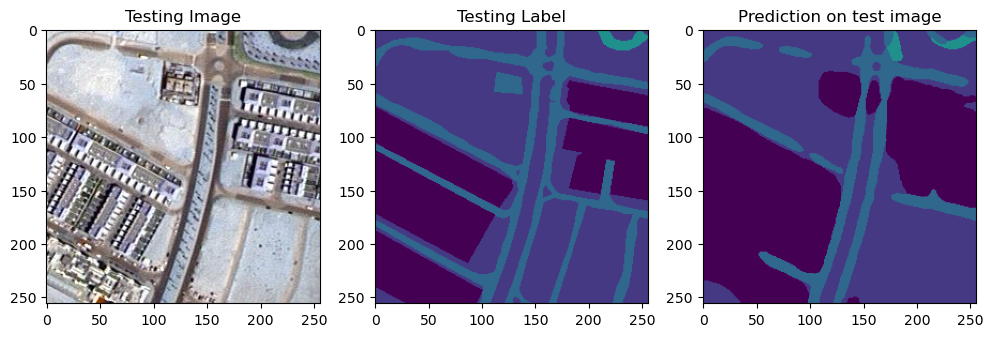

1/1 [==============================] - 0s 131ms/step


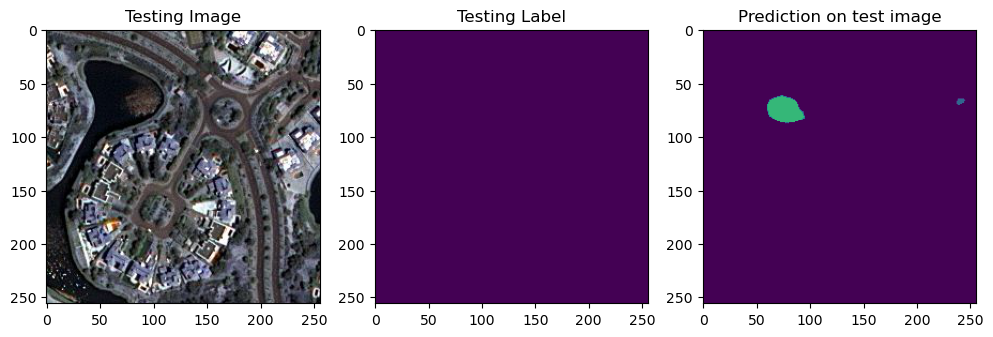

1/1 [==============================] - 0s 128ms/step


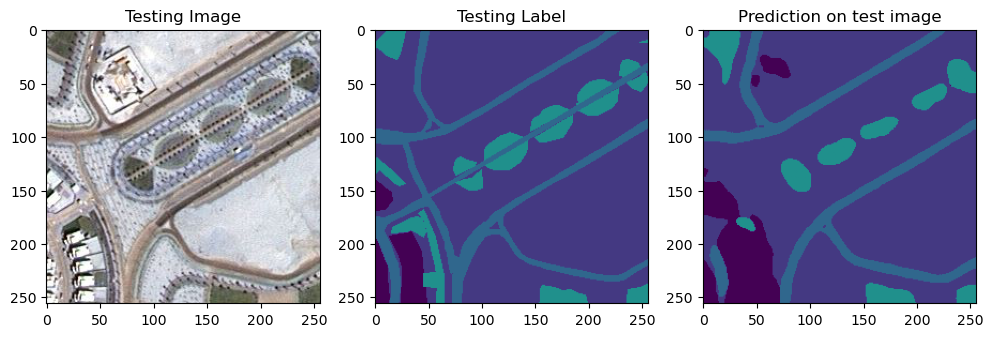

In [23]:
# Display part of the predicted samples after optimization
num_samples = 10
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model2.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()